In [48]:
import os
import json
from tbparse import SummaryReader
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import datetime
import glob

In [49]:
runs_folder = 'runs'
json_file = 'runs/per_epoch_data.json'
output_dir = 'plots'

metric_tags = [
    'Per-Epoch/Training Loss',
    'Per-Epoch/Training Perplexity',
    'Per-Epoch/Validation Loss',
    'Per-Epoch/Validation Perplexity'
]

In [50]:
def format_duration(seconds):
    """Converts a duration in seconds to a human-readable HH:MM:SS format."""
    if seconds is None or seconds < 0:
        return '00:00:00'
    # Round to nearest second for cleaner display
    delta = datetime.timedelta(seconds=round(seconds))
    return str(delta)

"""
Parses TensorBoard event files, calculates total training duration by summing
up individual event file durations, extracts specified scalar metrics, and
saves them to a JSON file.
"""

all_runs_data = {}
print(f'Searching for runs in: {runs_folder}')

for run_name in os.listdir(runs_folder):
    run_path = os.path.join(runs_folder, run_name)

    if os.path.isdir(run_path):
        print(f'Processing run: {run_name}')
        # Remove the '_1' from the runs
        run_name = run_name[:-2]

        try:
            # --- 1. Calculate Accurate Training Duration ---
            event_files = glob.glob(os.path.join(run_path, 'events.out.tfevents.*'))
            total_duration_sec = 0

            if not event_files:
                print('  > No event files found for this run.')

            for event_file in event_files:
                try:
                    file_reader = SummaryReader(event_file, extra_columns={'wall_time'})
                    events_df = file_reader.scalars
                    if not events_df.empty and 'wall_time' in events_df.columns and len(events_df) > 1:
                        duration = events_df['wall_time'].max() - events_df['wall_time'].min()
                        total_duration_sec += duration
                except Exception as e_file:
                    print(f'    > Warning: Could not process file {os.path.basename(event_file)}. Error: {e_file}')

            all_runs_data[run_name] = {
                'training_duration': {
                    'seconds': total_duration_sec,
                    'readable': format_duration(total_duration_sec)
                }
            }

            print(f'  > Calculated accurate training time: {format_duration(total_duration_sec)}')

            # --- 2. Extract Scalar Metrics ---
            reader = SummaryReader(run_path)
            df = reader.scalars
            filtered_df = df[df['tag'].isin(metric_tags)]

            if not filtered_df.empty:
                run_data_df = filtered_df.pivot(index='step', columns='tag', values='value')
                run_data_dict = run_data_df.to_dict(orient='index')
                run_data_dict = {str(k): v for k, v in run_data_dict.items()}

                all_runs_data[run_name]['metrics'] = run_data_dict
                print('  > Found and processed per-epoch metrics.')
            else:
                all_runs_data[run_name]['metrics'] = {}
                print(f'  > No desired per-epoch tags found for {run_name}.')

        except Exception as e:
            print(f'  > Could not process {run_name}. Error: {e}')

with open(json_file, 'w') as f:
    json.dump(all_runs_data, f, indent=4)

print(f'\nSuccessfully saved all data to {json_file}')

Searching for runs in: runs
Processing run: Phi-2_Large_1
  > Calculated accurate training time: 1 day, 20:56:18
  > Found and processed per-epoch metrics.
Processing run: Phi-2_Large_da_6_1
  > Calculated accurate training time: 9 days, 21:45:33
  > Found and processed per-epoch metrics.
Processing run: Phi-2_Medium_1
  > Calculated accurate training time: 1 day, 10:06:26
  > Found and processed per-epoch metrics.
Processing run: Phi-2_Medium_da_6_1
  > Calculated accurate training time: 6 days, 0:34:14
  > Found and processed per-epoch metrics.
Processing run: Phi-2_Small_1
  > Calculated accurate training time: 19:27:04
  > Found and processed per-epoch metrics.
Processing run: Phi-2_Small_da_6_1
  > Calculated accurate training time: 3 days, 11:04:16
  > Found and processed per-epoch metrics.

Successfully saved all data to runs/per_epoch_data.json


Generating training time and epoch comparison plot...


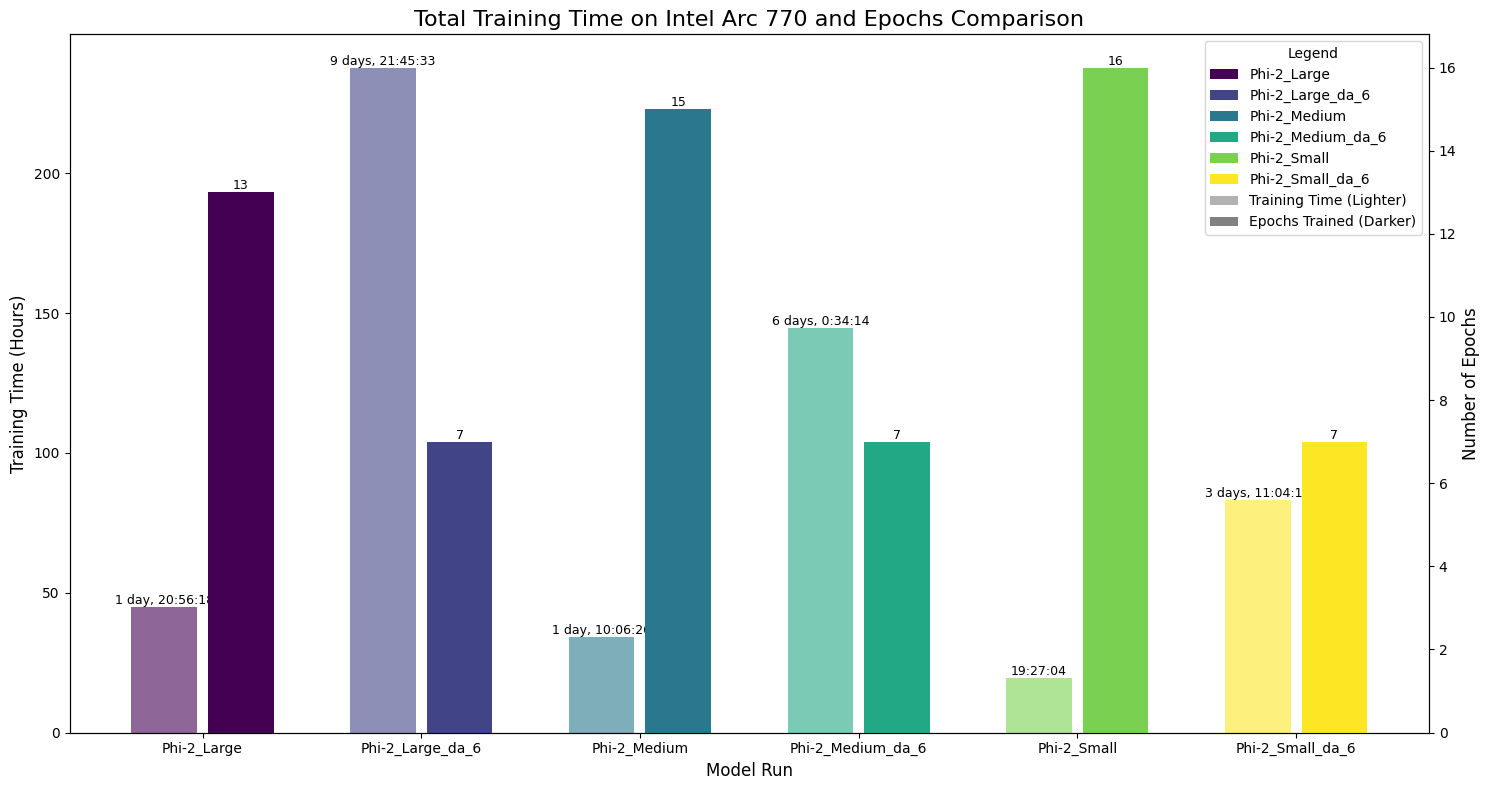


Generating plots for 4 metrics, separated by augmentation...
  > Plotting unaugmented models for Per-Epoch/Training Loss


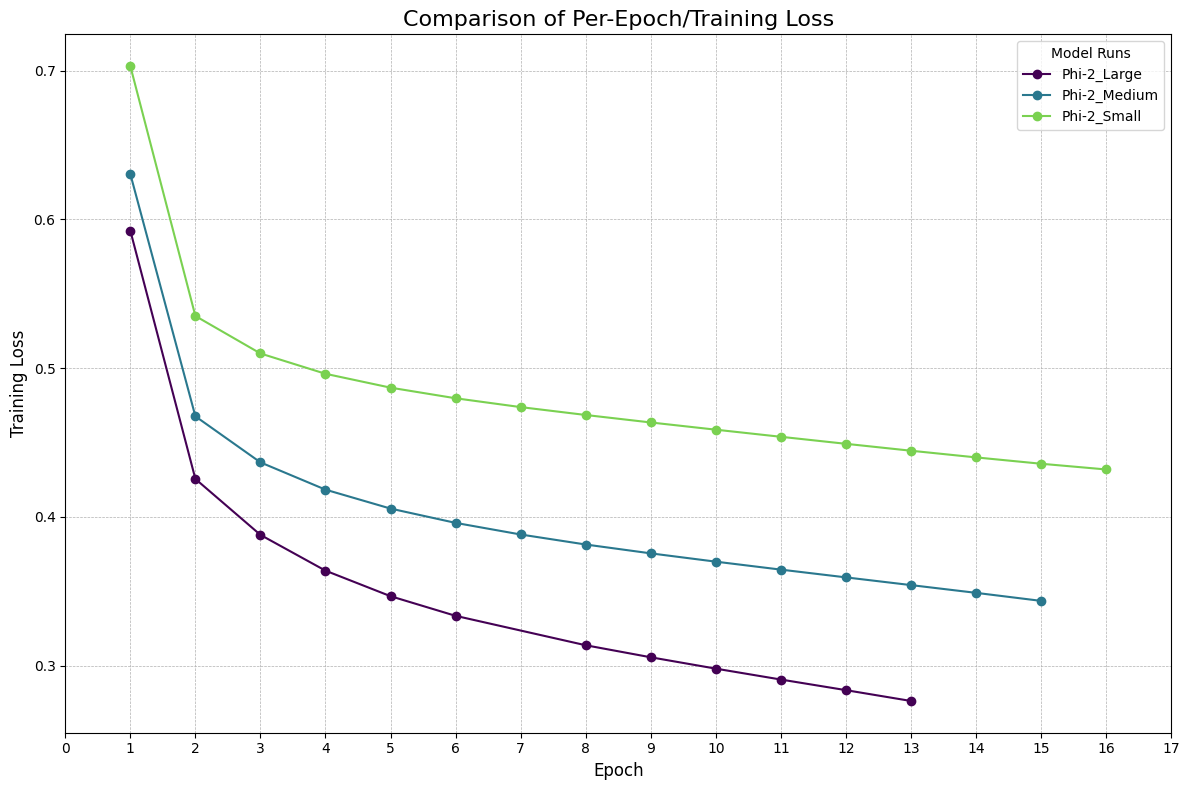

  > Plotting augmented models for Per-Epoch/Training Loss


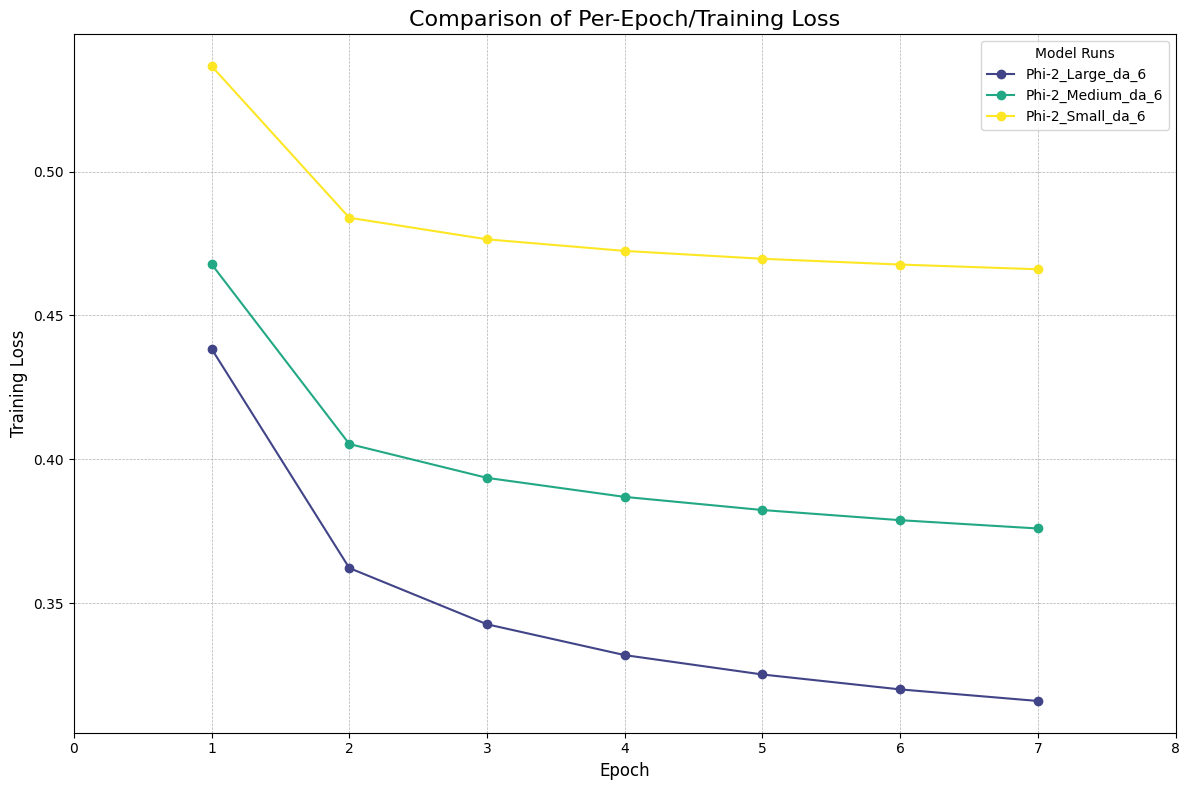

  > Plotting unaugmented models for Per-Epoch/Training Perplexity


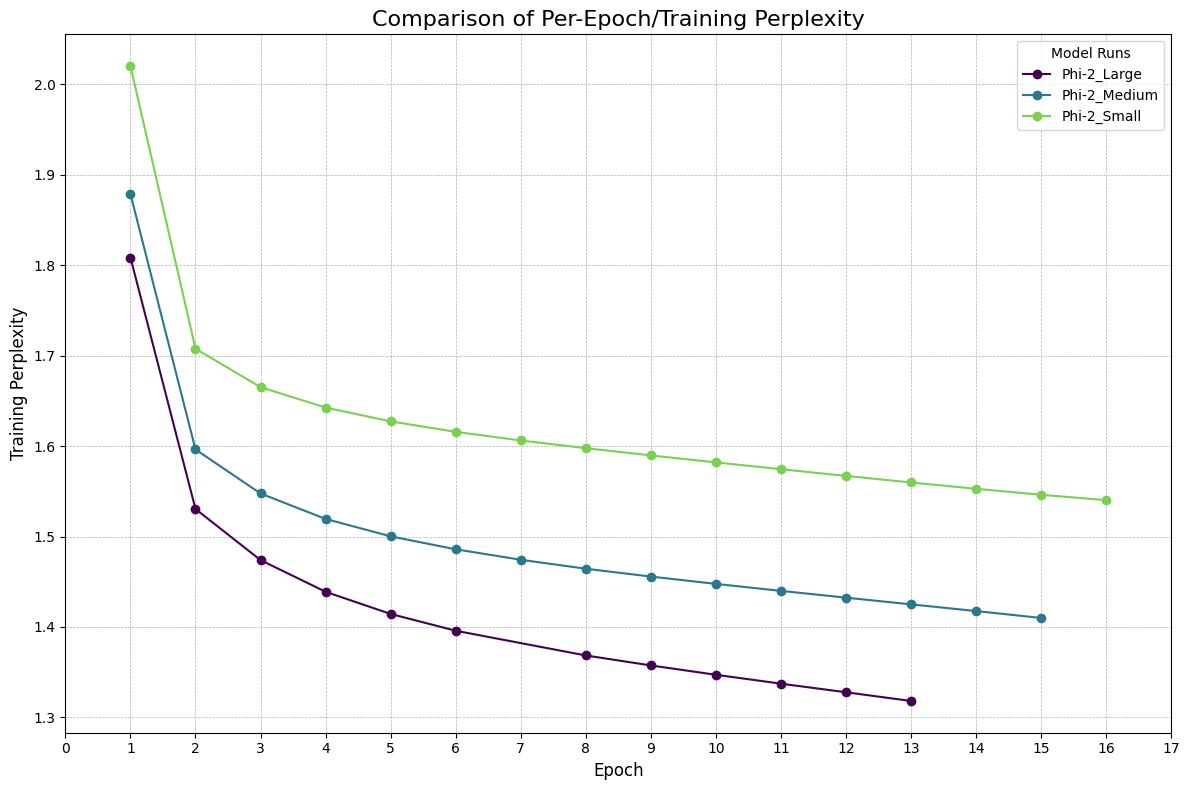

  > Plotting augmented models for Per-Epoch/Training Perplexity


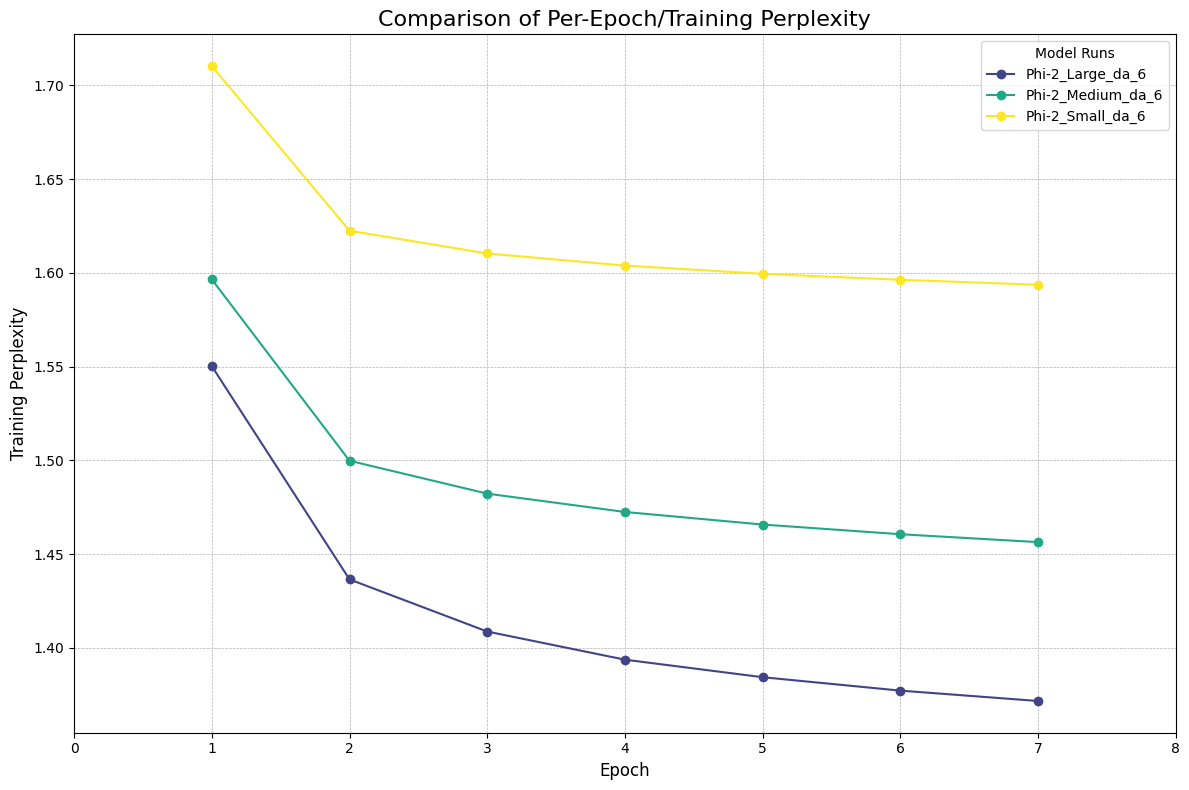

  > Plotting unaugmented models for Per-Epoch/Validation Loss


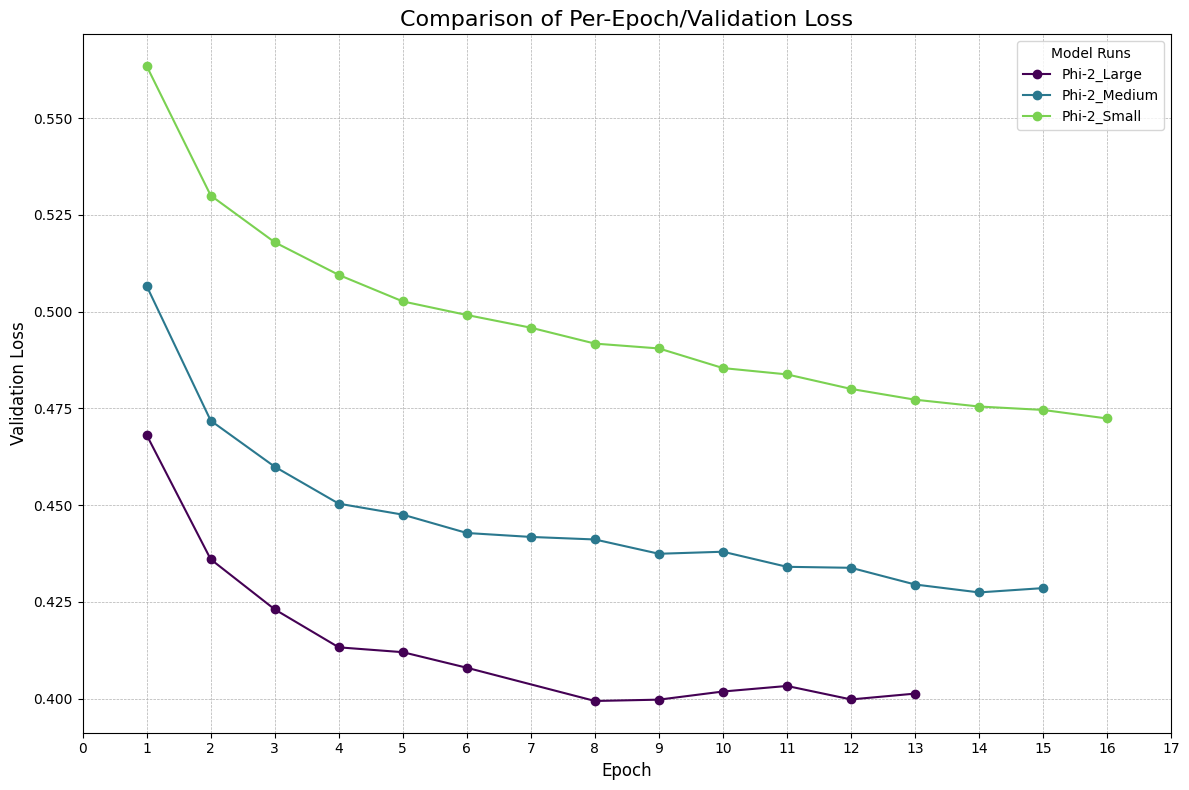

  > Plotting augmented models for Per-Epoch/Validation Loss


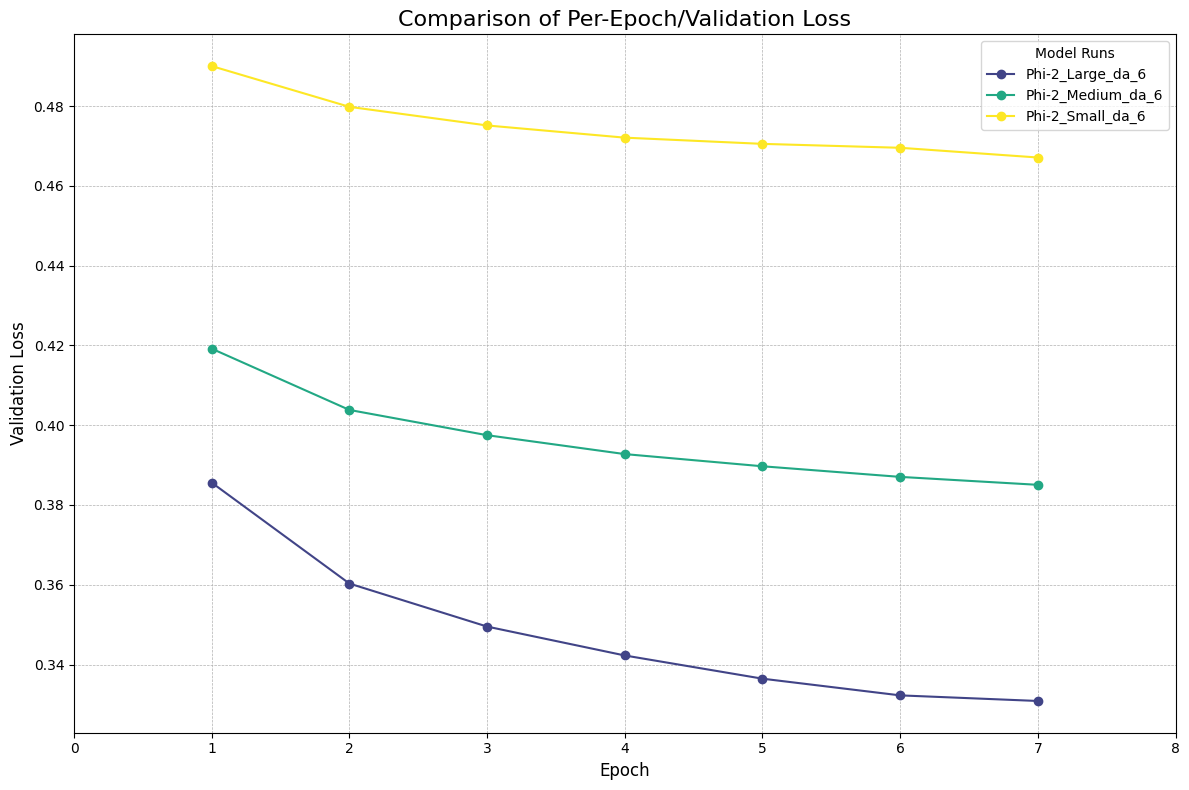

  > Plotting unaugmented models for Per-Epoch/Validation Perplexity


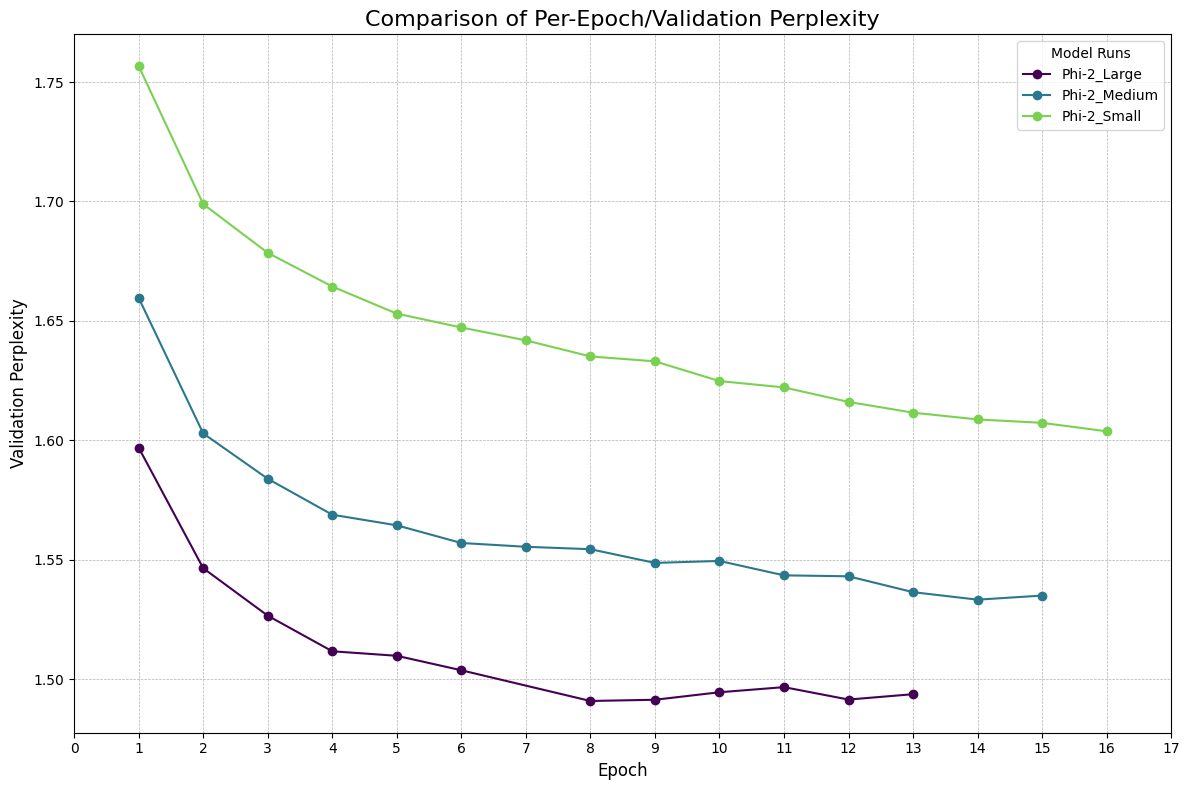

  > Plotting augmented models for Per-Epoch/Validation Perplexity


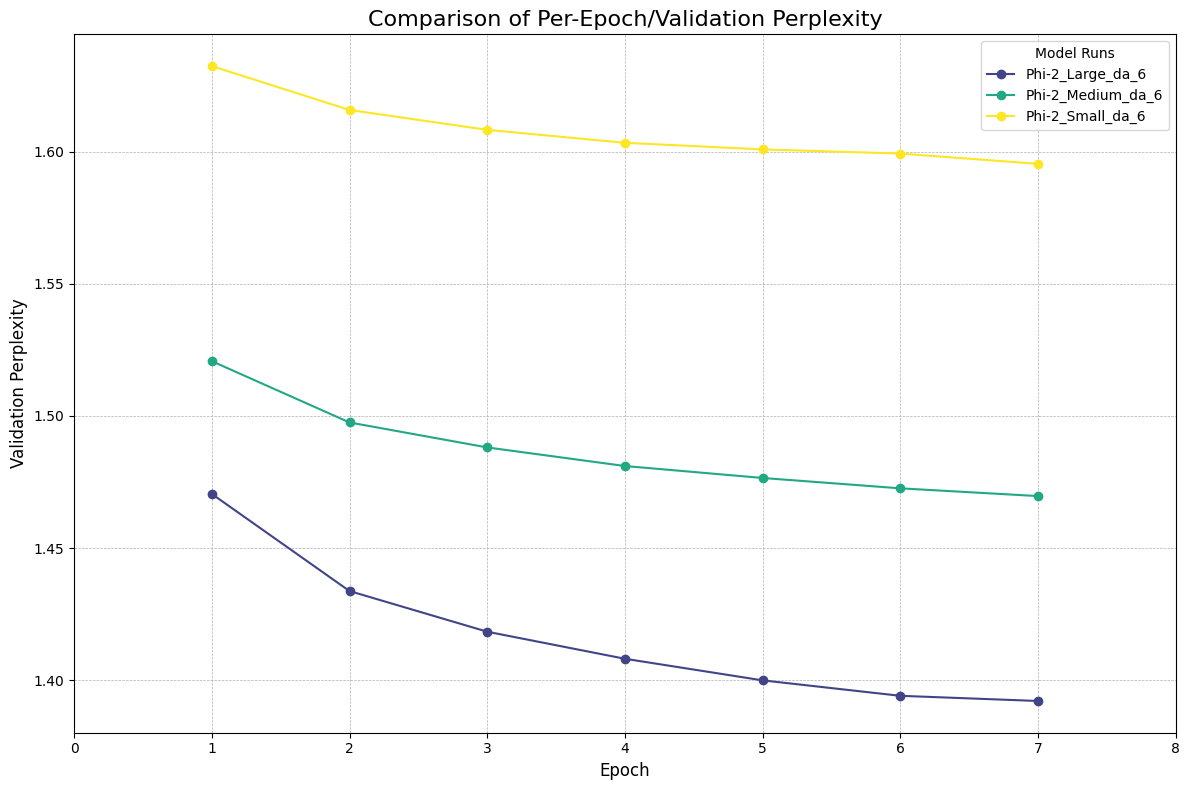


All plots generated successfully.


In [51]:
# Helper function to generate a single plot for a group of models
def generate_metric_plot(models_to_plot, filename_prefix, tag):
    fig, ax = plt.subplots(figsize=(12, 8))

    max_epoch = 0
    for model_name in models_to_plot:
        run_data = all_runs_data[model_name].get('metrics', {})
        epochs, values = [], []
        if not run_data: continue

        sorted_epochs = sorted(run_data.keys(), key=int)
        for epoch in sorted_epochs:
            if tag in run_data[epoch]:
                epochs.append(int(epoch))
                values.append(run_data[epoch][tag])

        if epochs:
            max_epoch = max(max_epoch, max(epochs))
            ax.plot(epochs, values, label=model_name, color=model_color_map[model_name], marker='o', linestyle='-')

    # --- Formatting the Plot ---
    ax.set_title(f'Comparison of {tag}', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(tag.split('/')[-1], fontsize=12)
    ax.legend(title='Model Runs', loc='upper right')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    if max_epoch > 0:
        ax.set_xticks(np.arange(0, max_epoch + 2, 1))

    plt.tight_layout()

    # --- Saving the Plot ---
    safe_tag_name = tag.replace('/', '_').replace(' ', '_')
    safe_filename = f'{filename_prefix}_{safe_tag_name}.png'
    output_path = os.path.join(output_dir, safe_filename)
    fig.savefig(output_path, dpi=300)
    plt.show()
    plt.close(fig)

"""
Reads processed TensorBoard data from a JSON file and generates plots
for each metric and a summary plot for training time.
"""

with open(json_file, 'r') as f:
    all_runs_data = json.load(f)

# Get all model names
model_names = list(all_runs_data.keys())

# Assign a unique color to each model, this will be used for all plots
colors = plt.get_cmap('viridis', len(model_names))
model_color_map = {model_name: colors(i) for i, model_name in enumerate(model_names)}

# --- 1. Plot Training Time and Epoch Comparison ---
print('Generating training time and epoch comparison plot...')

# Prepare data for the bar chart
durations_sec = [all_runs_data[name]['training_duration']['seconds'] for name in model_names]
durations_hr = [s / 3600 for s in durations_sec]

epoch_counts = []
for name in model_names:
    metrics = all_runs_data[name].get('metrics', {})
    if metrics:
        # Find the highest epoch number for the run
        max_epoch = max(map(int, metrics.keys()))
        epoch_counts.append(max_epoch)
    else:
        epoch_counts.append(0)

# Create a list of colors for the bars corresponding to each model
model_colors_list = [model_color_map[name] for name in model_names]

# --- Plotting ---
fig_bar, ax_bar = plt.subplots(figsize=(15, 8))
ax_epochs = ax_bar.twinx() # Create a second y-axis sharing the same x-axis

x = np.arange(len(model_names)) # the label locations
width = 0.30 # Make bars narrower to create more space
gap = 0.05   # the gap between a pair of bars

# Plot bars for training time, shifted left. Alpha is used to make it lighter.
rects1 = ax_bar.bar(x - width/2 - gap/2, durations_hr, width, color=model_colors_list, alpha=0.6)
# Plot bars for epoch count on the second y-axis, shifted right
rects2 = ax_epochs.bar(x + width/2 + gap/2, epoch_counts, width, color=model_colors_list)

# Add text labels on top of each bar
for i, rect in enumerate(rects1):
    height = rect.get_height()
    readable_time = all_runs_data[model_names[i]]['training_duration']['readable']
    ax_bar.text(rect.get_x() + rect.get_width() / 2., height,
                readable_time, ha='center', va='bottom', rotation=None, fontsize=9)

for i, rect in enumerate(rects2):
    height = rect.get_height()
    ax_epochs.text(rect.get_x() + rect.get_width() / 2., height,
                   f'{epoch_counts[i]}', ha='center', va='bottom', fontsize=9)


# --- Formatting the Plot ---
ax_bar.set_title('Total Training Time on Intel Arc 770 and Epochs Comparison', fontsize=16)
ax_bar.set_ylabel('Training Time (Hours)', fontsize=12)
ax_epochs.set_ylabel('Number of Epochs', fontsize=12)
ax_bar.set_xlabel('Model Run', fontsize=12)
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(model_names)
ax_bar.tick_params(axis='y')
ax_epochs.tick_params(axis='y')

# Create a custom legend for the models and bar types
legend_elements = [Patch(facecolor=model_color_map[name], label=name) for name in model_names]
legend_elements.append(Patch(facecolor='grey', alpha=0.6, label='Training Time (Lighter)'))
legend_elements.append(Patch(facecolor='grey', label='Epochs Trained (Darker)'))
ax_bar.legend(handles=legend_elements, title='Legend', loc='upper right')


fig_bar.tight_layout() # Adjust layout to prevent labels from being cut off

# Save and show the plot
bar_chart_path = os.path.join(output_dir, 'training_summary_comparison.png')
fig_bar.savefig(bar_chart_path, dpi=300)
plt.show()
plt.close(fig_bar)


# --- 2. Plot Per-Epoch Metrics ---
# Dynamically find all unique metric tags from the data
metric_tags = set()
for model in model_names:
    if 'metrics' in all_runs_data[model] and all_runs_data[model]['metrics']:
        first_epoch_key = next(iter(all_runs_data[model]['metrics']))
        metric_tags.update(all_runs_data[model]['metrics'][first_epoch_key].keys())

# Separate models into augmented and unaugmented groups
augmented_models = [name for name in model_names if '_da' in name]
unaugmented_models = [name for name in model_names if '_da' not in name]

print(f'\nGenerating plots for {len(metric_tags)} metrics, separated by augmentation...')

# Create plots for each group for each metric
for tag in sorted(list(metric_tags)):
    if unaugmented_models:
        print(f'  > Plotting unaugmented models for {tag}')
        generate_metric_plot(unaugmented_models,'unaugmented', tag)
    if augmented_models:
        print(f'  > Plotting augmented models for {tag}')
        generate_metric_plot(augmented_models, 'augmented', tag)

print('\nAll plots generated successfully.')